# Text Classification with Finetuning benchmarked against FastText

We follow [Howard and Ruder (2018)](https://arxiv.org/abs/1801.06146) approach on finetuning language models for text classification. The language model used is the one previously trained--the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182). The dataset is NECTEC's [BEST](https://thailang.nectec.or.th/best/), which is labeled as article, encyclopedia, news and novel. We preprocessed to remove the segmentation token and used an 80/20 split for training and validation. This resulted in 119241 sentences in the training and 29250 sentences in the validation set. We achieved 94.4% accuracy of four-label classification using the finetuning model as compared to 65.2% by [fastText](fasttext.cc) using their own [pretrained embeddings](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md). 

## Imports

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import re
import random
import shutil

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from IPython.display import Image
from IPython.core.display import HTML 

from fastai.learner import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

from pythainlp.tokenize import word_tokenize

import dill as pickle
from IPython.display import Image
from IPython.core.display import HTML 

PATH='/home/ubuntu/data/best/'
MODEL_PATH = '/home/ubuntu/data/thaiwiki/models/'

RAW_PATH = 'raw/'
TRN_PATH = 'train/'
VAL_PATH = 'valid/'

RAW = f'{PATH}{RAW_PATH}'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

labels = ['article','encyclopedia','news','novel']

## Data Processing

We did minimal text processing for [BEST](https://thailang.nectec.or.th/best/), only removing the unnecessary word segmentors. Our segmentation is powered by [pyThaiNLP](https://github.com/PyThaiNLP/pythainlp) as in the language modeling example. We also created a custom torchtext object in order to be loaded by the data loader of the model. The train-validation split is at 80/20.

### Extract

In [23]:
# for label in labels:
#     raw_files = !ls '{RAW}/{label}' 
#     for fname in raw_files:
#         raw_txt = !cat '{RAW}/{label}/{fname}'
#         cleaned_doc = []
#         for line in raw_txt:
#             new_line = ''.join(line.split('|')[:-1])
#             new_line = re.sub('<[^>]*>','',new_line)
#             cleaned_doc.append(new_line)
#         new_doc = '\n'.join(cleaned_doc)
#         with open(f"{TRN}/{label}/{fname}", "w") as text_file:
#             text_file.write(new_doc)
#         text_file.close()

### Train-validation split

In [24]:
# valid_split = 0.2
# for label in labels:
#     trn_files = !ls '{TRN}{label}' 
#     random.shuffle(trn_files)
#     val_files = trn_files[:int(np.round(valid_split * len(trn_files)))]
#     for file in val_files:
#         if file.endswith(".txt") & (file in val_files):
#             shutil.move(f'{TRN}{label}/{file}',f'{VAL}{label}')

### Torchtext Dataset

In [25]:
class BESTDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for label in labels:
            for fname in iglob(os.path.join(path, label, '*.txt')):
                with open(fname, 'r') as f: 
                    text = f.readlines()
                    for line in text:
                        examples.append(data.Example.fromlist([line, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', **kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

## Finetuning

In the similar manner as image classification, we performed finetuning using stochastic gradient descent with resets according to these steps:

1. Load encoding layer previously trained
1. Unfreeze the last layer and train
1. Unfreeze all layers and train using differential learning rates, with smallest learning rate at the first layer and so on
1. Train with longer cycle length until the model overfits

In this example, we have made very minimal changes compared to the [fast.ai](http://www.fast.ai/) example in order to show that the "default" settings already are performing quite well at 94.4% accuracy before overfitting.

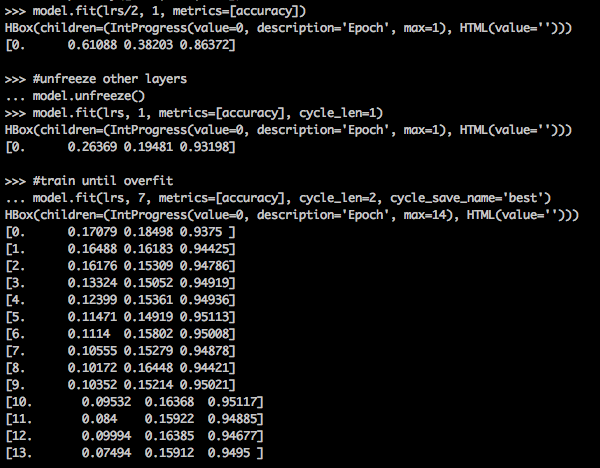

In [6]:
Image(filename= "/home/ubuntu/data/thaiwiki/png/classification_train.png")

In [4]:
#load the text object
TEXT_vec = pickle.load(open(f'{MODEL_PATH}TEXT_vec.pkl','rb'))

In [ ]:
#get splits
BEST_LABEL = data.Field(sequential=False)
splits = BESTDataset.splits(TEXT_vec, BEST_LABEL, PATH, train='train', test='valid')

In [7]:
#get data loader
bs = 32
bptt = 70
md = TextData.from_splits(PATH, splits, bs)

In [19]:
#model parameters
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers
lrs=np.array([1e-4,1e-3,1e-2]) #differential learning rate

#model setup
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
model = md.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
model.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)

#get saved encoder
model.load_encoder(f'{MODEL_PATH}adam3_enc')
model.clip=25.

In [ ]:
#unfreeze last layer
model.freeze_to(-1)
model.fit(lrs, 1, metrics=[accuracy])

In [ ]:
#unfreeze and fit other layers
model.unfreeze()
model.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

In [ ]:
#train until overfit
model.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='best')

## fastText

We used [fastText](fasttext.cc)'s own [pretrained embeddings](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) and a relatively "default" settings in order to benchmark our results. This gave us 65.2% accuracy for four-label classification.

### Data Processing

In [19]:
# train_set = []
# for label in labels:
#     trn_files = !ls '{TRN}{label}'
#     for fname in trn_files:
#         with open(f'{TRN}{label}/{fname}','r') as f:
#             text = f.readlines()
#             for line in text:
#                 train_set.append(f'__label__{label} {line}')
# len(train_set)
# train_doc = ''.join(train_set)
# with open(f'{TRN}train.txt','w') as f:
#     f.write(train_doc)

In [3]:
with open(f'{TRN}train.txt','r') as f:
    cnt = len(f.readlines())
print(cnt)

119241


In [20]:
# valid_set = []
# for label in labels:
#     val_files = !ls '{VAL}{label}'
#     for fname in val_files:
#         with open(f'{VAL}{label}/{fname}','r') as f:
#             text = f.readlines()
#             for line in text:
#                 valid_set.append(f'__label__{label} {line}')
# len(valid_set)
# valid_doc = ''.join(valid_set)
# with open(f'{VAL}valid.txt','w') as f:
#     f.write(valid_doc)

In [2]:
with open(f'{VAL}valid.txt','r') as f:
    cnt = len(f.readlines())
print(cnt)

29250


### Modeling

In [38]:
!fasttext supervised -input '{TRN}train.txt' -pretrainedVectors '{MODEL_PATH}wiki.th.vec' -epoch 10 -dim 300 -wordNgrams 2 -output '{MODEL_PATH}model'

Read 0M words
Number of words:  460855
Number of labels: 4
Progress: 100.0% words/sec/thread:  547652 lr:  0.000000 loss:  0.126899 ETA:   0h 0m


In [40]:
!fasttext test '{MODEL_PATH}model.bin' '{VAL}valid.txt'

N	29249
P@1	0.653
R@1	0.652
Number of examples: 29249


### Evaluation

In [7]:
pred = !fasttext predict '{MODEL_PATH}model.bin' '{VAL}valid.txt'

In [10]:
correct = []
with open(f'{VAL}valid.txt','r') as f:
    for line in f.readlines():
        correct.append(line.split(' ')[0])

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(correct,pred)

0.6524786324786325